In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# Important values

In [59]:
#Molar masses
M = {
    "Li": 6.940,
    "Na": 22.990,
    "Mg": 24.305,
    "Al": 26.982,
    "Si": 28.085,
    "P": 30.974,
    "K": 39.098,
    "Ca": 40.078,
    "Sc": 44.956,
    "Ti": 47.867,
    "V": 50.942,
    "Cr": 51.996,
    "Mn": 54.938,
    "Fe": 55.845,
    "Co": 58.933,
    "Ni": 58.693,
    "Cu": 63.546,
    "Zn": 65.380,
    "Ga": 69.723,
    "Y": 88.906,
    "Zr": 91.224
}

In [60]:
#Conversion factors only for major elements in oxides
Cf = {
    "Na": 0.741857,
    "Mg": 0.603036,
    "Al": 0.529251,
    "Si": 0.467439,
    "P": 0.436421,
    "K": 0.830147,
    "Ca": 0.714701,
    "Ti": 0.599508,
    "Cr": 0.684202,
    "Mn": 0.774457,
    "Fe": 0.777311,
}

In [61]:
#Element list for functions
iso_to_el = {
    "7Li": "Li",
    "23Na": "Na",
    "25Mg": "Mg",
    "27Al": "Al",
    "29Si": "Si",
    "31P": "P",
    "39K": "K",
    "44Ca": "Ca",
    "49Ti": "Ti",
    "52Cr": "Cr",
    "55Mn": "Mn",
    "57Fe": "Fe",
    "45Sc": "Sc",
    "51V": "V",
    "59Co": "Co",
    "60Ni": "Ni",
    "63Cu": "Cu",
    "66Zn": "Zn",
    "69Ga": "Ga",
    "89Y": "Y",
    "90Zr": "Zr",
}

# Functions

In [62]:
#Convert to mass fraction
def to_mass_fraction(df):
    df = df.copy()

    # wt% → mass fraction
    wt_cols = df.filter(regex=r"\(%m/m\)").columns
    df[wt_cols] = df[wt_cols].apply(pd.to_numeric, errors="coerce") / 100.0
    df.rename(
        columns={c: c.replace("(%m/m)", "(mf)") for c in wt_cols},
        inplace=True
    )

    # µg/g → mass fraction
    ug_cols = df.filter(regex=r"\(µg/g\)").columns
    df[ug_cols] = df[ug_cols].apply(pd.to_numeric, errors="coerce")
    df.rename(
        columns={c: c.replace("(µg/g)", "(ppm)") for c in ug_cols},
        inplace=True
    )

    return df

#Convert to elements the oxides
def apply_oxide_correction(df, iso_to_el, Cf):
    df = df.copy()
    for iso, el in iso_to_el.items():
        old = f"{iso} (mf)"
        new = f"{iso}_elem"

        if old not in df.columns:
            continue

        if el in Cf:
            df[old] *= Cf[el]

        df.rename(columns={old: new}, inplace=True)

    return df

#Compute mol%
def compute_mol_percent(df, iso_to_el, M):
    df = df.copy()

    for iso, el in iso_to_el.items():
        old = f"{iso}_elem"
        new = f"{iso}_mol"

        if old not in df.columns:
            continue

        if el not in M:
            raise KeyError(f"Missing molar mass for {el}")

        df[old] /= M[el]
        df.rename(columns={old: new}, inplace=True)

    mean_df = df[df["data"] == "mean"].copy()

    mol_cols = [col for col in mean_df.columns if col.endswith("_mol")]

    mean_df["mol_sum"] = mean_df[mol_cols].sum(axis=1)

    for col in mol_cols:
        mean_df[col] = mean_df[col] / mean_df["mol_sum"] * 100
        mean_df.rename(columns={col: col.replace("_mol", "_mol_pct")}, inplace=True)

    mean_df.drop(columns=["mol_sum"], inplace=True)

    return mean_df

#Process all the sample with the above functions
def process_sample(df, iso_to_el, Cf, M):
    stages = {}

    stages["raw"] = df.copy()

    stages["mass_fraction"] = to_mass_fraction(
        stages["raw"]
    )

    stages["oxide_corrected"] = apply_oxide_correction(
        stages["mass_fraction"], iso_to_el, Cf
    )

    stages["mol_percent"] = compute_mol_percent(
        stages["oxide_corrected"], iso_to_el, M
    )

    return stages

def build_combined_dataframe(pipeline):
    """
    Combine major elements from 'mol_percent' with trace elements from 'oxide_corrected'
    """
    major = pipeline["mol_percent"].copy()
    trace = pipeline["oxide_corrected"].copy()

    # Filter to "mean" rows only in trace data (same as in mol_percent)
    trace = trace[trace["data"] == "mean"]

    # Get only columns that end with _ppm (trace elements)
    ppm_cols = [col for col in trace.columns if col.endswith("_ppm")]

    # Add back the id columns needed for merging
    trace = trace[ppm_cols + ["sample name", "POS"]]

    # Merge mol% with ppm trace data
    combined = pd.merge(major, trace, on=["sample name", "POS"], how="left")

    return combined



# Import the data

Remember to change the path witht the one in your pc
Un-comment for when the POS029 is being processed

In [ ]:
#file path to your file containing the data for the POS sample.
#It is important that before importing the CSV file you have done "text to colum" in excel.
file_path058 = r"/home/daniela/Documents/GeoPlanet/S3_NU/LabAnalysis/LA-ICP-MS/reducedData/POS09-058.average-results.csv"
file_path038 = r"/home/daniela/Documents/GeoPlanet/S3_NU/LabAnalysis/LA-ICP-MS/reducedData/POS09-038-Daniela.average-results.csv"
file_path039 = r"/home/daniela/Documents/GeoPlanet/S3_NU/LabAnalysis/LA-ICP-MS/reducedData/POS09-039.average-results.csv"
file_path040 = r"/home/daniela/Documents/GeoPlanet/S3_NU/LabAnalysis/LA-ICP-MS/reducedData/POS09-040-DELMAS.average-results.csv"
file_path072 = r"/home/daniela/Documents/GeoPlanet/S3_NU/LabAnalysis/LA-ICP-MS/reducedData/POS09-072-Daniela.average-results.csv"
file_path029 = r"/home/daniela/Documents/GeoPlanet/S3_NU/LabAnalysis/LA-ICP-MS/reducedData/POS09-029-Daniela.average-results.csv"


POS058 = pd.read_csv(
    file_path058,
    sep="\t",
    decimal=","
)

POS058 = POS058.apply(pd.to_numeric, errors="ignore")
POS058.replace(to_replace=0, value = np.nan, inplace=True)

POS038 = pd.read_csv(
    file_path038,
    sep="\t",
    decimal=","
)

POS038 = POS038.apply(pd.to_numeric, errors="ignore")
POS038.replace(to_replace=0, value = np.nan, inplace=True)

POS039 = pd.read_csv(
    file_path039,
    sep="\t",
    decimal=","
)

POS039 = POS039.apply(pd.to_numeric, errors="ignore")
POS039.replace(to_replace=0, value = np.nan, inplace=True)

POS040 = pd.read_csv(
    file_path040,
    sep="\t",
    decimal=","
)

POS040 = POS040.apply(pd.to_numeric, errors="ignore")
POS040.replace(to_replace=0, value = np.nan, inplace=True)

#If sample POS09-072 wants to be plotted uncomment the following:
'''
POS072 = pd.read_csv(
    file_path072,
    sep="\t",
    decimal=","
)

POS072 = POS072.apply(pd.to_numeric, errors="ignore")
POS072.replace(to_replace=0, value = np.nan, inplace=True)
'''

POS029 = pd.read_csv(
    file_path029,
    sep="\t",
    decimal=","
)

POS029 = POS029.apply(pd.to_numeric, errors="ignore")
POS029.replace(to_replace=0, value = np.nan, inplace=True)


#Dictionary with sample for easy processing
samples = {
    "POS09-058": POS058,
    "POS09-040": POS040,
    "POS09-038": POS038,
    #If sample POS09-072 wants to be plotted uncomment the following:
    #"POS09-072": POS072,
    "POS09-039": POS039,
    "POS09-029": POS029,
}


# Data processing

In [82]:
pipelines = {}
combined = {}

for name, df in samples.items():
    df = df.copy()
    df["POS"] = name  # Add POS column for trace element merging
    pipelines[name] = process_sample(df, iso_to_el, Cf, M)
    combined[name] = build_combined_dataframe(pipelines[name])


Each samples has 4 stage of processing: raw (original data), mass_fraction, oxide_corrected and mol_percent.
To access any of this stages, if you want to check the associated values, the syntax is:
- pipelines["name of the sample"]["stage"]

In [83]:
### Example


pipelines["POS09-058"]["oxide_corrected"]

,data,sample name,comment,7Li (ppm),23Na_elem,...,66Zn (ppm),69Ga (ppm),89Y (ppm),90Zr (ppm),POS
0,mean,BHVO-2G,NaN,NaN,0.017794,...,104.299680,22.119041,26.177322,171.830400,POS09-058
1,stdev,BHVO-2G,NaN,NaN,0.004106,...,63.333130,2.798064,2.348755,19.954120,POS09-058
2,mean,BHVO-2G,NaN,NaN,0.018145,...,106.217040,22.007797,26.124653,170.753020,POS09-058
3,stdev,BHVO-2G,NaN,NaN,0.004224,...,57.438070,2.923733,2.608767,22.314922,POS09-058
4,mean,BCR-2G,NaN,NaN,0.024901,...,122.906920,30.300140,35.806440,184.825230,POS09-058
5,stdev,BCR-2G,NaN,NaN,0.005688,...,59.625510,4.361930,3.373778,22.434376,POS09-058
6,mean,BIR-2G,NaN,NaN,0.015056,...,73.037450,14.910815,15.842397,14.447786,POS09-058
7,stdev,BIR-2G,NaN,NaN,0.004087,...,47.512310,2.340083,1.682691,2.242399,POS09-058
8,mean,TG-01,NaN,NaN,NaN,...,81.593000,NaN,0.117387,NaN,POS09-058
9,stdev,TG-01,NaN,NaN,NaN,...,48.732250,NaN,0.028678,NaN,POS09-058


## Extract the last stage (mol%) for all sample

In [84]:
mol_mean = {}
mol_stdev = {}

for name, pipe in pipelines.items():
    df = pipe["mol_percent"]

    mol_mean[name] = df[df["data"] == "mean"].copy()
    mol_stdev[name] = df[df["data"] == "stdev"].copy()

The variables mol_mean and mol_stdev contain the mean values and stdev values of mol% for all target (not only TG but also the standards) across all samples.

In [86]:
tg_means = []

for name, df in mol_mean.items():
    tg = df[df["sample name"].str.startswith("TG")].copy()
    tg["POS"] = name
    tg_means.append(tg)

tg_all = pd.concat(tg_means, ignore_index=True)

The variable tg_all contains the mol% values across all samples but only for the target TG

# Reproducibility test

DEFINITION: The same sample measured in different POS files gives consistent results within uncertainty.
The code compares the results (in mol%) for the standards across all POS sample and sees how different they are.
The count corresponds to how many standards for that type are found.

For the moment it works for only an element

In [87]:
# list of elements
elements = [col for col in mol_mean[next(iter(mol_mean))].columns if col.endswith("_mol_pct")]

# list to collect all summaries
all_rows = []

for element in elements:
    rows = []
    for pos, df in mol_mean.items():
        tmp = df[["sample name", element]].copy()
        tmp["POS"] = pos
        rows.append(tmp)

    repro_df = pd.concat(rows, ignore_index=True)

    # select standards only (non-TG)
    standards = repro_df[~repro_df["sample name"].str.startswith("TG")].dropna()

    # compute summary
    summary = (
        standards
        .groupby("sample name")[element]
        .agg(["mean", "std", "count"])
    )
    summary["RSD_%"] = 100 * summary["std"] / summary["mean"]
    summary["element"] = element
    summary.reset_index(inplace=True)

    all_rows.append(summary)

# combine everything into one DataFrame
repro_summary_df = pd.concat(all_rows, ignore_index=True)

repro_summary_df

#Remove the comment to export the data as csv
#repro_summary_df.to_csv("repro_summary.csv", index=False)

,sample name,mean,std,count,RSD_%,element
0,BCR-2G,6.330902,0.283314,10,4.475098,23Na_mol_pct
1,BHVO-2G,4.389439,0.063052,16,1.436458,23Na_mol_pct
2,BIR-1G,3.560379,0.201957,9,5.672351,23Na_mol_pct
3,BIR-2G,3.640914,NaN,1,NaN,23Na_mol_pct
4,MongOl,0.032287,0.001579,7,4.890529,23Na_mol_pct
5,BCR-2G,5.059196,0.135057,10,2.669529,25Mg_mol_pct
6,BHVO-2G,10.028402,0.120452,16,1.201108,25Mg_mol_pct
7,BIR-1G,13.397778,0.360207,9,2.688557,25Mg_mol_pct
8,BIR-2G,13.032028,NaN,1,NaN,25Mg_mol_pct
9,MongOl,58.552652,0.638204,9,1.089966,25Mg_mol_pct


| RSD (%) | Meaning                                                |
| ------- | ------------------------------------------------------ |
| < 1%    | Very high precision / very reproducible measurements   |
| 1 – 5%  | Good precision / acceptable reproducibility            |
| 5 – 10% | Moderate reproducibility; some variability             |
| > 10%   | Poor reproducibility; measurements are quite scattered |


# Fo# vs trace elements

First, based on the Chromite graph we exclude sample TG-08-01 (chromite), TG-22 (cpx) and TG-12-02-BZ (matrix)

In [88]:
samples_to_remove = ["TG-08-01", "TG-22", "TG-12-02-BZ"]

tg_all_ = tg_all[
    ~(
        (tg_all["POS"] == "POS09-072") &
        (tg_all["sample name"].isin(samples_to_remove))
    )
].copy()

Now, the Fo# values for all TG across POS sample are computed

### Fosterite content

In [89]:
mg_col = "25Mg_mol_pct"
fe_col = "57Fe_mol_pct"

tg_all_["Fo_number"] = (
    100 * tg_all_[mg_col] /
    (tg_all_[mg_col] + tg_all_[fe_col])
).where(
    tg_all_[[mg_col, fe_col]].notna().all(axis=1)
)

### Mg content through KD

In [90]:
KD = 0.3

tg_all_["Mg#_melt"] = (
    (KD * tg_all_[mg_col]) /
    (KD * tg_all_[mg_col] + tg_all_[fe_col])
).where(
    tg_all_[[mg_col, fe_col]].notna().all(axis=1)
)

In [91]:
tg_all_[["sample name", "POS", mg_col, fe_col, "Fo_number", "Mg#_melt"]].head()

,sample name,POS,25Mg_mol_pct,57Fe_mol_pct,Fo_number,Mg#_melt
0,TG-01,POS09-058,56.714482,9.162477,86.091530,0.649977
1,TG-03,POS09-058,57.273189,8.013020,87.726321,0.681960
2,TG-04,POS09-058,57.493770,8.570628,87.026859,0.668046
3,TG-05,POS09-058,56.628344,8.905852,86.410375,0.656070
4,TG-07,POS09-058,55.800112,9.439940,85.530453,0.639421


In [92]:
#Define colors for POS sample that will be consistent through plots
pos_list = sorted(tg_all_["POS"].dropna().unique())
cmap = plt.get_cmap("tab10")
pos_colors = {pos: cmap(i % cmap.N) for i, pos in enumerate(pos_list)}

## Plot a single element

Choose in **element** the element you want to plot. The name is with the same syntax element_mol_pct

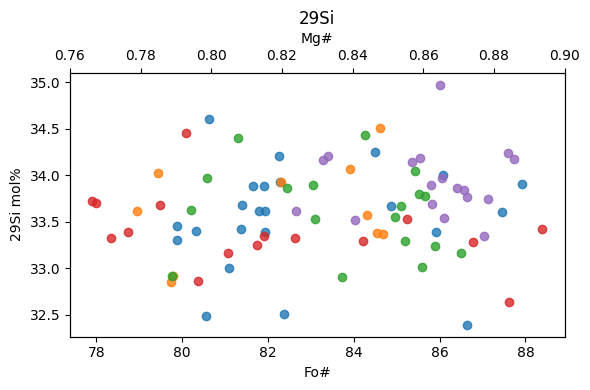

In [93]:
# Choose the element you want to plot
element = "29Si_mol_pct"  # change to any single element

# -------------------------------
# Create figure and axis
# -------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

# -------------------------------
# Plot data by POS
# -------------------------------
plot_df = tg_all_[
    ["Fo_number", "Mg#_melt", element, "POS"]
].dropna()

for pos, g in plot_df.groupby("POS"):
    ax.scatter(
        g["Fo_number"],
        g[element],
        color=pos_colors[pos],
        alpha=0.8
    )

ax.set_xlabel("Fo#")
ax.set_ylabel(element.replace("_mol_pct", " mol%"))
ax.set_title(f"{element.replace('_mol_pct', '')}")

# -------------------------------
# Top x-axis (Mg#)
# -------------------------------
ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())

fo_ticks = ax.get_xticks()
mg_ticks = fo_ticks / 100.0

ax_top.set_xticks(fo_ticks)
ax_top.set_xticklabels([f"{mg:.2f}" for mg in mg_ticks])
ax_top.set_xlabel("Mg#")

plt.tight_layout()

# -------------------------------
# Save figure (optional)
# -------------------------------
#fig.savefig(f"{element}_Fo_Mg_plot.png", dpi=300, bbox_inches='tight')
plt.show()


## Plot all elements with a zoom

In [95]:
tg_all_.columns[3:3+21]

Index(['7Li (ppm)', '23Na_mol_pct', '25Mg_mol_pct', '27Al_mol_pct',
       '29Si_mol_pct', '31P_mol_pct', '39K_mol_pct', '44Ca_mol_pct',
       '45Sc (ppm)', '49Ti_mol_pct', '51V (ppm)', '52Cr (ppm)', '55Mn_mol_pct',
       '57Fe_mol_pct', '59Co (ppm)', '60Ni (ppm)', '63Cu (ppm)', '66Zn (ppm)',
       '69Ga (ppm)', '89Y (ppm)', '90Zr (ppm)'],
      dtype='object')

In [98]:
min(tg_all_['Mg#_melt']), max(tg_all_['Mg#_melt'])

(0.514040363127562, 0.695447334660378)

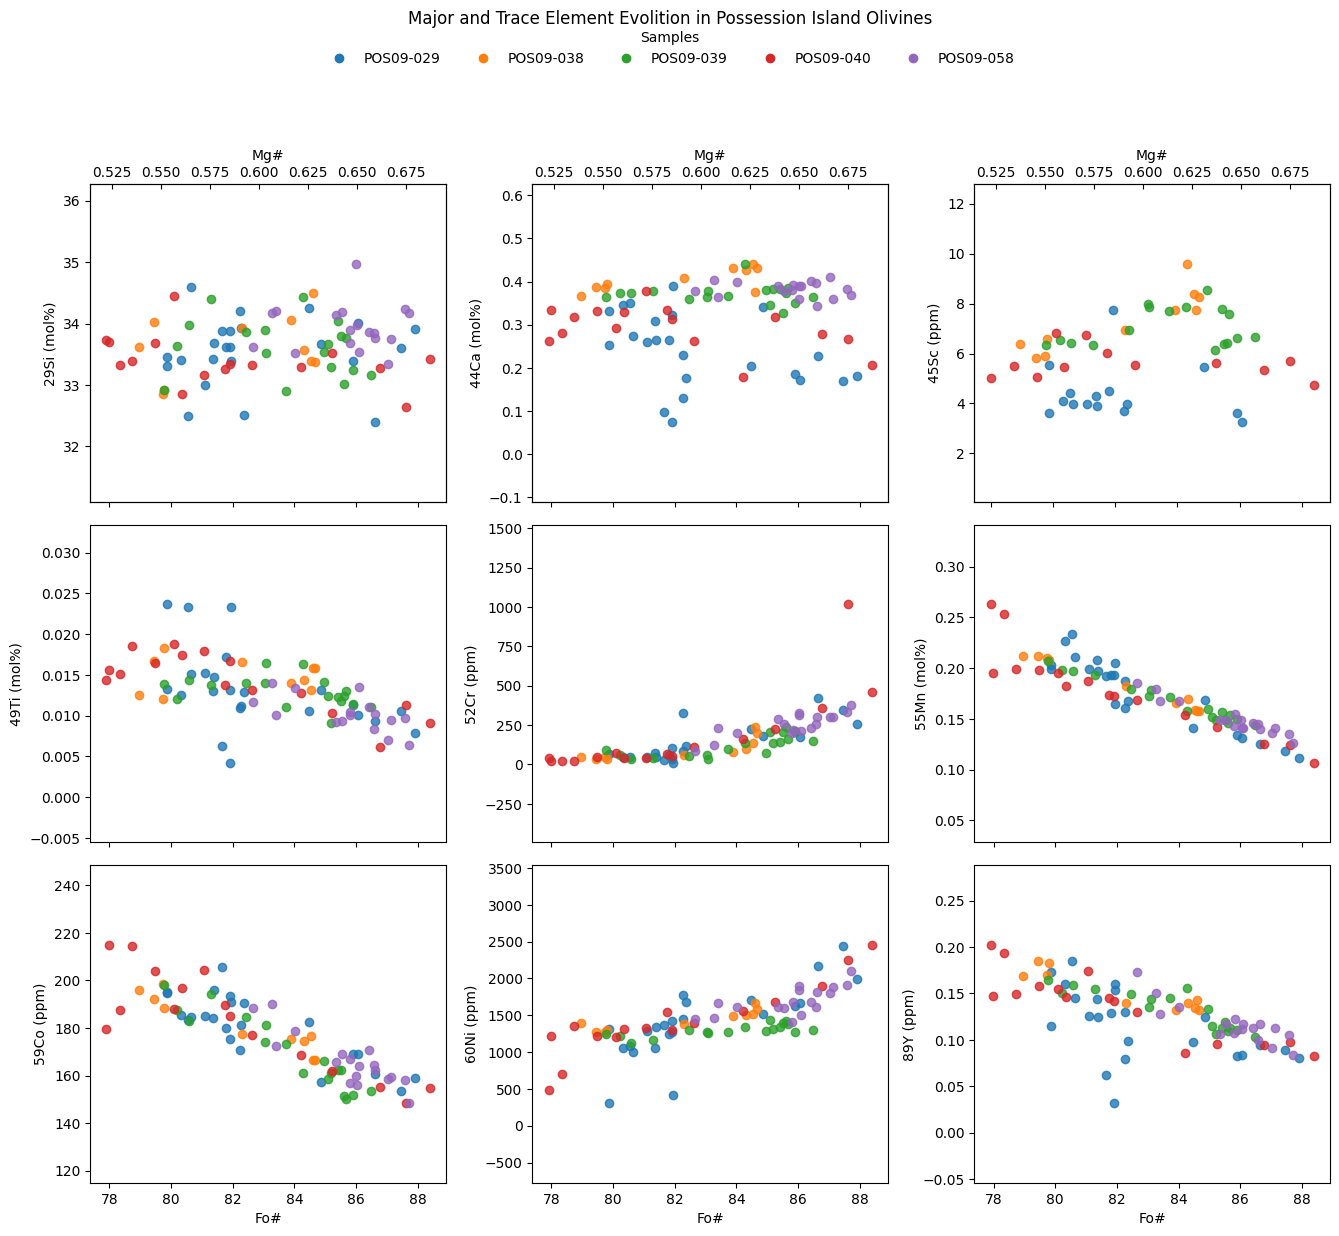

In [100]:

# For plotting only elements for the report (expluded: Fe, Mg, Al, Ga, Cu, Zn, Zr, V, K, P, Li, Na)

elements_to_plot = ['29Si_mol_pct', '44Ca_mol_pct', '45Sc (ppm)', '49Ti_mol_pct', '52Cr (ppm)', '55Mn_mol_pct',
       '59Co (ppm)', '60Ni (ppm)', '89Y (ppm)']
ncols = 3
figname = "TG_samples_plot_zoom50%_report_without072.png"




nrows = math.ceil(len(elements_to_plot) / ncols)

element_grid = [
    elements_to_plot[i:i+ncols]
    for i in range(0, len(elements_to_plot), ncols)
]


# -------------------------------
# fixed POS → color mapping
# -------------------------------
pos_list = sorted(tg_all_["POS"].dropna().unique())
cmap = plt.get_cmap("tab10")
pos_colors = {pos: cmap(i % cmap.N) for i, pos in enumerate(pos_list)}

# -------------------------------
# figure + axes
# -------------------------------
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(4.5 * ncols, 3.8 * nrows),
    sharex=False
)

# -------------------------------
# plotting
# -------------------------------
for i in range(nrows):
    for j, element in enumerate(element_grid[i]):


        ax = axes[i, j]
        element = element_grid[i][j]

        # skip element if column missing
        if element not in tg_all_.columns:
            ax.set_visible(False)
            continue

        plot_df = tg_all_[["Fo_number", "Mg#_melt", element, "POS"]].dropna()

        # scatter plotting by POS
        for pos, g in plot_df.groupby("POS"):
            ax.scatter(
                g["Fo_number"],
                g[element],
                color=pos_colors[pos],
                alpha=0.8
            )

        ax.set_ylabel(element.replace("_mol_pct", " (mol%)"))


         #hide x tick labels except bottom row
        if i != nrows - 1:
            ax.tick_params(labelbottom=False)

        # CHANGE HERE IN MARGIN THE % VALUE OF ZOOMING OUT
        # local y-axis limits with 10% margin
        ymin = plot_df[element].min()
        ymax = plot_df[element].max()
        margin = 0.50 * (ymax - ymin) if ymax > ymin else 1.0  # handle zero-range
        ax.set_ylim(ymin - margin, ymax + margin)



# -----------------------------
# top x-axis (Mg#) – independent
# -----------------------------
mg_min = min(tg_all_['Mg#_melt'])
mg_max = max(tg_all_['Mg#_melt'])

for j in range(ncols):

    ax_top = axes[0, j].twiny()   # independent x-axis

    ax_top.set_xlim(mg_min, mg_max)   # choose independently
    ax_top.set_xlabel("Mg#")

    ax_top.tick_params(axis="x", direction="in")



# -------------------------------
# bottom x-axis label (Fo#)
# -------------------------------
for ax in axes[-1, :]:
    ax.set_xlabel("Fo#")

# -------------------------------
# single horizontal legend above figure
# -------------------------------
handles = [
    plt.Line2D(
        [0], [0],
        marker="o",
        linestyle="",
        color=pos_colors[pos],
        label=pos
    )
    for pos in pos_list
]

fig.legend(
    handles=handles,
    title="Samples",
    loc='lower center',             # align bottom of legend at anchor
    bbox_to_anchor=(0.5, 1.02),    # centered above figure
    ncol=len(pos_list),             # spread across all POS
    frameon=False
)

# -------------------------------
# figure title
# -------------------------------
fig.suptitle(
    "Major and Trace Element Evolition in Possession Island Olivines",
    y=1.08  # move up to avoid overlapping legend
)

for i in range(nrows):
    for j in range(len(element_grid[i]), ncols):
        axes[i, j].set_visible(False)

plt.tight_layout()

# -------------------------------
# save figure 
# -------------------------------
fig.savefig(figname, dpi=300, bbox_inches='tight')
plt.show()

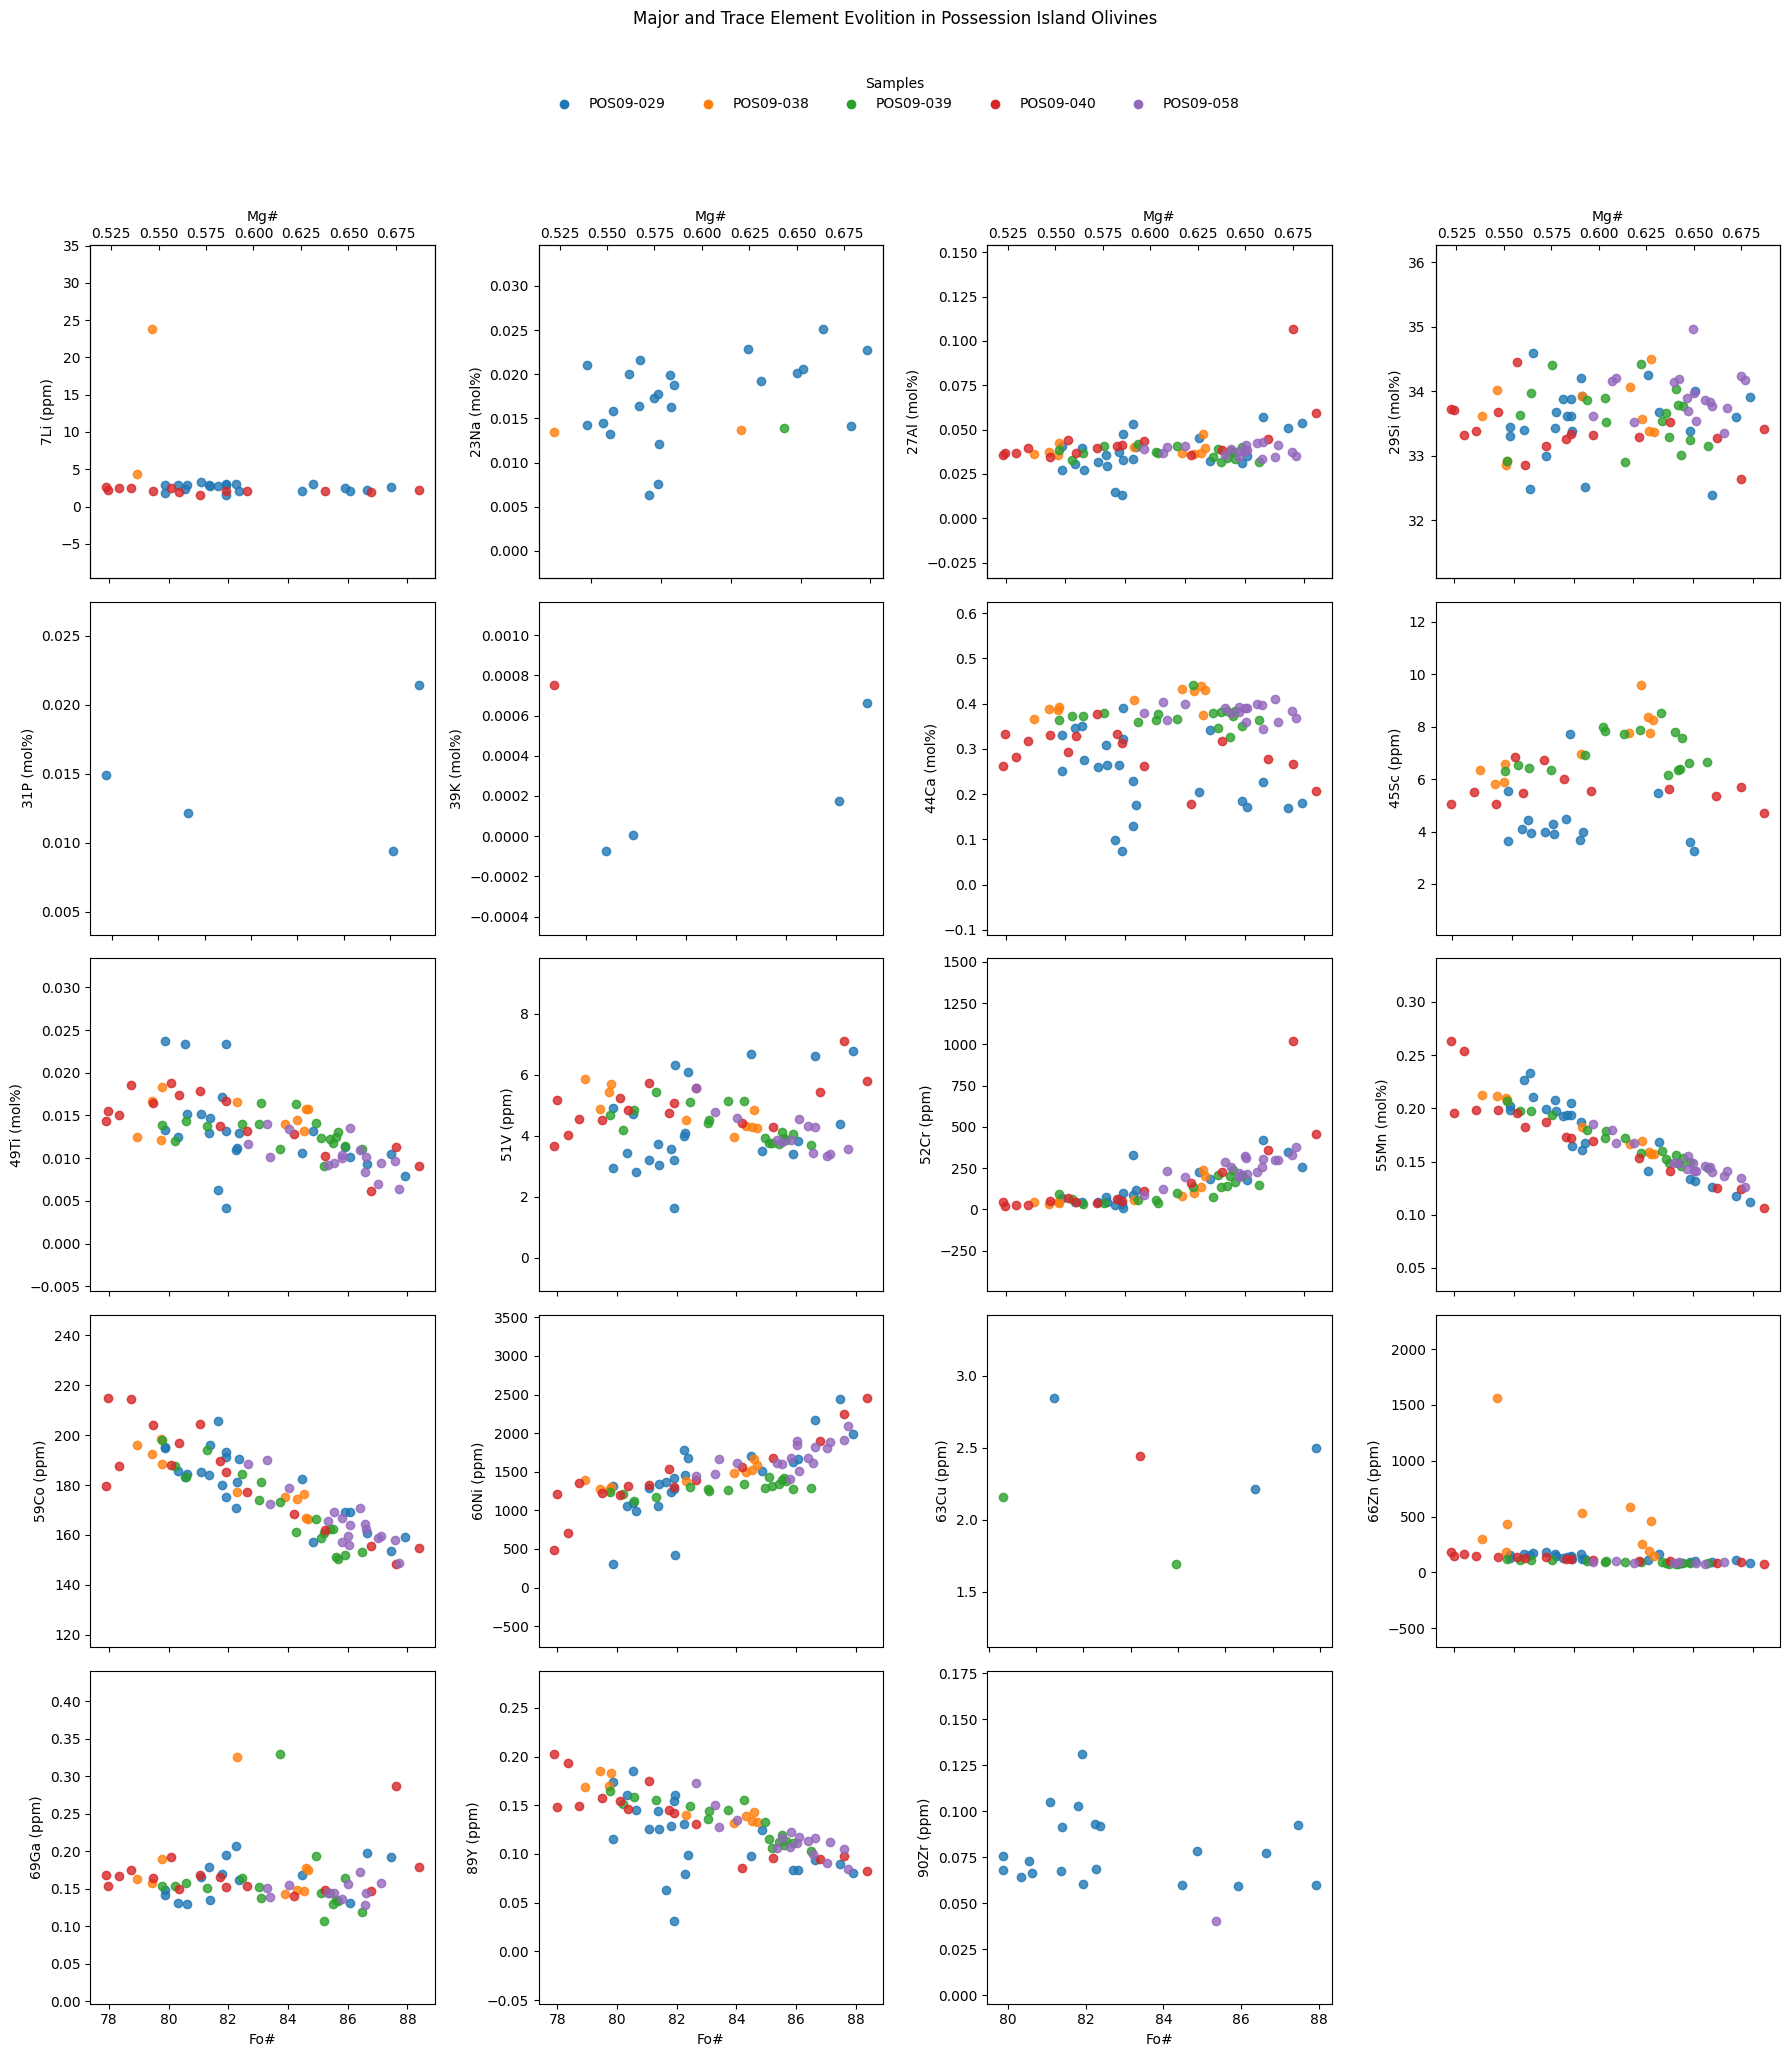

In [101]:
# For plotting all elements

elements_to_plot = ['7Li (ppm)', '23Na_mol_pct', '27Al_mol_pct',
       '29Si_mol_pct', '31P_mol_pct', '39K_mol_pct', '44Ca_mol_pct',
       '45Sc (ppm)', '49Ti_mol_pct', '51V (ppm)', '52Cr (ppm)', '55Mn_mol_pct',
       '59Co (ppm)', '60Ni (ppm)', '63Cu (ppm)', '66Zn (ppm)',
       '69Ga (ppm)', '89Y (ppm)', '90Zr (ppm)']
ncols = 4
figname = "TG_samples_plot_zoom50%_allElements.png"



nrows = math.ceil(len(elements_to_plot) / ncols)

element_grid = [
    elements_to_plot[i:i+ncols]
    for i in range(0, len(elements_to_plot), ncols)
]


# -------------------------------
# fixed POS → color mapping
# -------------------------------
pos_list = sorted(tg_all_["POS"].dropna().unique())
cmap = plt.get_cmap("tab10")
pos_colors = {pos: cmap(i % cmap.N) for i, pos in enumerate(pos_list)}

# -------------------------------
# figure + axes
# -------------------------------
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(4.5 * ncols, 3.8 * nrows),
    sharex=False
)

# -------------------------------
# plotting
# -------------------------------
for i in range(nrows):
    for j, element in enumerate(element_grid[i]):


        ax = axes[i, j]
        element = element_grid[i][j]

        # skip element if column missing
        if element not in tg_all_.columns:
            ax.set_visible(False)
            continue

        plot_df = tg_all_[["Fo_number", "Mg#_melt", element, "POS"]].dropna()

        # scatter plotting by POS
        for pos, g in plot_df.groupby("POS"):
            ax.scatter(
                g["Fo_number"],
                g[element],
                color=pos_colors[pos],
                alpha=0.8
            )

        ax.set_ylabel(element.replace("_mol_pct", " (mol%)"))


         #hide x tick labels except bottom row
        if i != nrows - 1:
            ax.tick_params(labelbottom=False)

        # CHANGE HERE IN MARGIN THE % VALUE OF ZOOMING OUT
        # local y-axis limits with 10% margin
        ymin = plot_df[element].min()
        ymax = plot_df[element].max()
        margin = 0.50 * (ymax - ymin) if ymax > ymin else 1.0  # handle zero-range
        ax.set_ylim(ymin - margin, ymax + margin)



# -----------------------------
# top x-axis (Mg#) – independent
# -----------------------------
mg_min = min(tg_all_['Mg#_melt'])
mg_max = max(tg_all_['Mg#_melt'])

for j in range(ncols):

    ax_top = axes[0, j].twiny()   # independent x-axis

    ax_top.set_xlim(mg_min, mg_max)   # choose independently
    ax_top.set_xlabel("Mg#")

    ax_top.tick_params(axis="x", direction="in")



# -------------------------------
# bottom x-axis label (Fo#)
# -------------------------------
for ax in axes[-1, :]:
    ax.set_xlabel("Fo#")

# -------------------------------
# single horizontal legend above figure
# -------------------------------
handles = [
    plt.Line2D(
        [0], [0],
        marker="o",
        linestyle="",
        color=pos_colors[pos],
        label=pos
    )
    for pos in pos_list
]

fig.legend(
    handles=handles,
    title="Samples",
    loc='lower center',             # align bottom of legend at anchor
    bbox_to_anchor=(0.5, 1.02),    # centered above figure
    ncol=len(pos_list),             # spread across all POS
    frameon=False
)

# -------------------------------
# figure title
# -------------------------------
fig.suptitle(
    "Major and Trace Element Evolition in Possession Island Olivines",
    y=1.08  # move up to avoid overlapping legend
)

for i in range(nrows):
    for j in range(len(element_grid[i]), ncols):
        axes[i, j].set_visible(False)

plt.tight_layout()

# -------------------------------
# save figure 
# -------------------------------
fig.savefig(figname, dpi=300, bbox_inches='tight')
plt.show()